In [1]:
from src.database import DatabaseXRD,snip,Phase,MixPhase
from src.gaussnewton import GaussNewton
from numpy import newaxis,loadtxt,diag,histogram,arange,linspace,sin,concatenate,array,exp,pi,zeros,ones,prod,newaxis,arctan,savetxt,c_,fabs,sqrt,concatenate
from numpy.random import normal
from numpy.linalg import pinv,inv
from scipy.optimize import curve_fit,least_squares
from scipy.interpolate import interp1d
from scipy.signal import find_peaks

from matplotlib.pyplot import imshow,plot,show,vlines,xlim,ylim,figure,semilogx,scatter,xlabel,ylabel,subplots,gca,savefig

from glob import glob

from scipy import signal
from numpy import fft,pad,concatenate,stack

from src.spectra import Spectra
from src.xrd_data import DataXRD

In [2]:
database = DatabaseXRD().read_cifs('Database/')

calcite = database['Calcite'][0]
hydrocerussite = database['Hydrocerussite'][0]
cinnabar = database['Cinnabar'][2]
spinel = database['Spinel'][0]
barite = database['Barite'][0]
lazurite = database['Lazurite'][0]

In [3]:
xrd_data = DataXRD().load_h5('/home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M491/ProfiloXRD/data.h5')

Loading: /home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M491/ProfiloXRD/data.h5
Load inverted
Load convoluted


In [4]:
def fce_calibration(x,a,beta,s):
    return (arctan((x+a)/s)) * 180 / pi + beta

In [5]:
files = glob('Profilo/Lazurite/roi*.dat')
phase = MixPhase([cinnabar,lazurite])

xrd_gauss_newton = []
xrd_spectra = []

for file in files:
    
    spectra = Spectra(file)
    spectra.calibrate_from_file('/home/zdenek/Projects/pyMaXRDXRF/Oslo/Calibration1/M0795/CappelloGialloXRD/calibration.ini')
    spectra.convolve(4).raw_snip(m=16)
    
    xrd_gauss_newton += [GaussNewton(phase,spectra)]

(0.0, 1280.0)

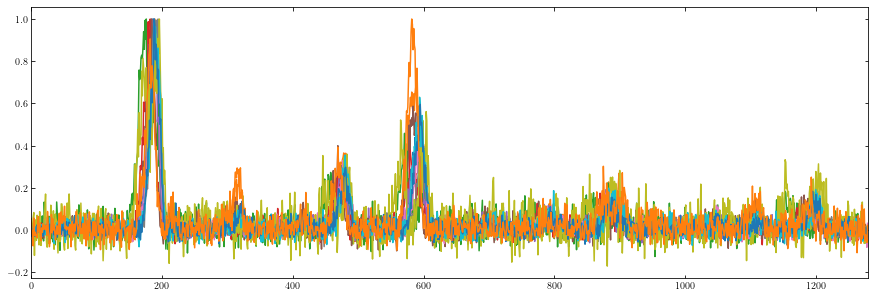

In [6]:
figure(figsize=(15,5))
for g in xrd_gauss_newton:
    plot(g.spectra.intensity)
xlim(0,1280)

[-1167.7226182112686, 51.00000000000008, 1919.5184277547212] 7.023649044031371
[-1178.4312525912183, 51.0, 1937.2266022438912] 4.371983152182189
[-1200.3270806816079, 50.99999999999978, 2005.5536204062157] 6.822851416037424
[-1175.1625932522575, 50.99999999999996, 1945.1363085051128] 1.4340130501973498
[-1184.8917993892328, 51.00000000000001, 1954.8595133847712] 1.4119071611148146
[-1173.931517663419, 50.999999999999865, 1940.7319887335411] 2.3932139963682015
[-1190.320111388861, 50.99999999999992, 1959.703997739076] 1.4358010290643723
[-1158.4659309783085, 51.000000000000355, 1893.5288505247918] 8.622552165952532
[-1202.4763283566729, 50.999999999999844, 1985.4503881118492] 13.54302325876745
[-1188.0943828995973, 51.00000000000001, 1953.319876910128] 2.1243465278783455
[-1170.8921916085803, 51.000000000000064, 1922.6299829273287] 8.754481411312831
[-1172.664894172415, 50.99999999999994, 1938.5394605475924] 4.307610583675883


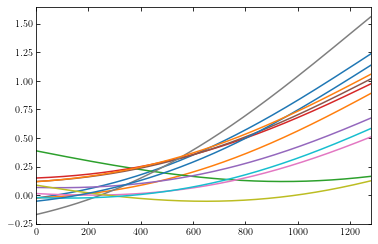

In [7]:
x = arange(1280)
    
for g in xrd_gauss_newton:
    
    g.spectra.opt = [-1186.106076632754, 51., 1954.6937605682037]
    
    for _ in range(4):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()

    print(g.spectra.opt,g.dz)
    
    opt = g.spectra.opt
    opt_file = g.spectra.opt_file
    
    y_new = fce_calibration(x,*opt)
    y_old = fce_calibration(x,*opt_file)
    
    plot(y_new-y_old)
    xlim(0,1280)

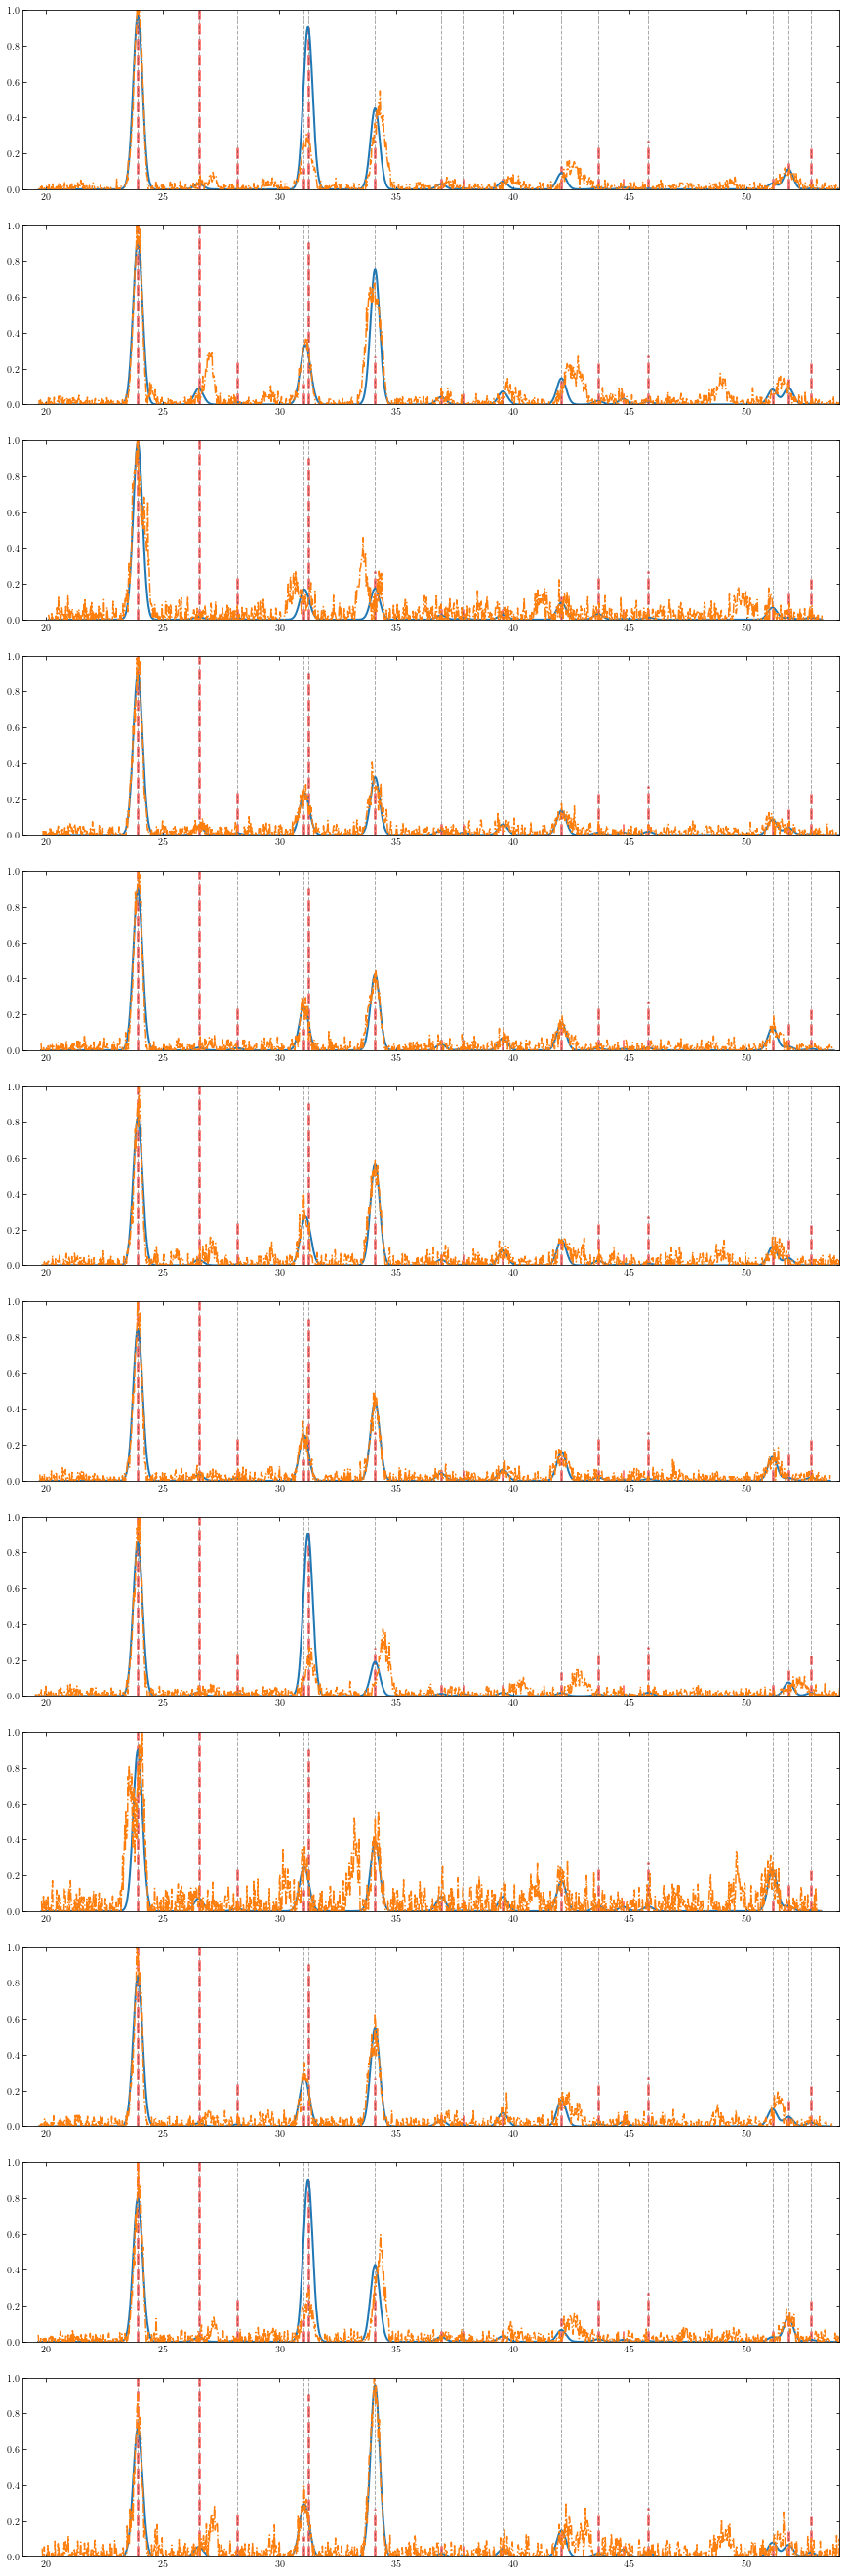

In [8]:
%matplotlib inline
fig,ax = subplots(len(xrd_gauss_newton),1,figsize = (15,48))

for i,g in enumerate(xrd_gauss_newton):
    
    g.spectra.opt = g.opt.copy()
    s = g.spectra
    
    ax[i].vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
    ax[i].plot(g.theta,g.z,'-',lw=2)
    ax[i].plot(s.theta,s.intensity,'-.')
    ax[i].vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)
    
    ax[i].vlines(g.mu[g.gamma<0],0,1,'c',alpha=1,ls='--',lw=3)
    
    ax[i].set_xlim(19,54)
    ax[i].set_ylim(0,1)

In [9]:
%%time

data = xrd_data.inverted.reshape(-1,1280)
profilo_gauss_newton = []

for d in data[:]:
    spectra = Spectra()
    spectra.from_array(d)
    spectra.opt[:] = array([-1185.2366578999117, 50.99999999999997, 1955.6511408474753])
    spectra.convolve(4).raw_snip(m=16)
    
    g = GaussNewton(phase,spectra)
    
    for _ in range(4):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()

    #print(g.spectra.opt)
    
    profilo_gauss_newton += [g]
    

CPU times: user 7min 38s, sys: 259 ms, total: 7min 39s
Wall time: 7min 39s


In [35]:
%%time
for g in profilo_gauss_newton:
    for _ in range(4):
        g.calibration_nobeta(alpha=1)
        g.opt = g.spectra.opt.copy()

CPU times: user 1min 57s, sys: 5.55 ms, total: 1min 57s
Wall time: 1min 57s


In [16]:
out = array([g.dz for g in profilo_gauss_newton])
out = out.reshape(95,170)

In [15]:
f = (a > -1150)
out[f] = 100

In [16]:
f = (xrd_data.inverted[:,:,185] < 50)
out[f] = 100

In [17]:
out.shape,xrd_data.inverted.shape

((95, 170), (95, 170, 1280))

In [21]:
out.max(),out.min()

(112.41935553947928, 0.24574004577705602)

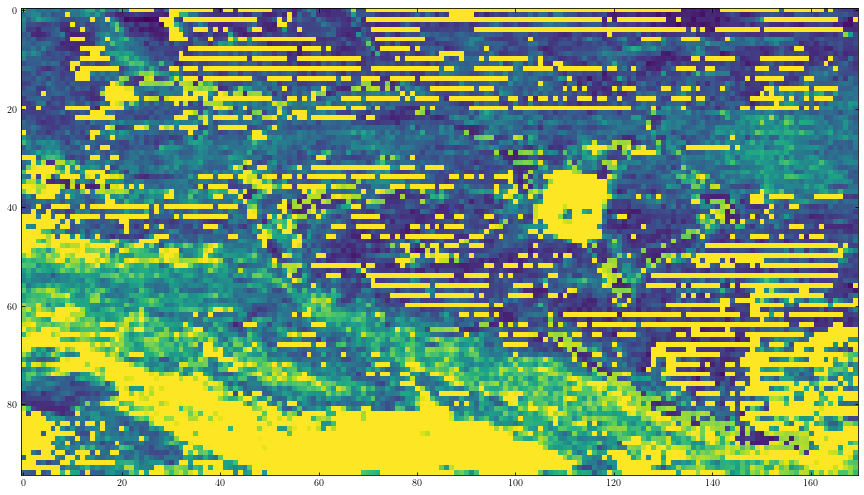

In [26]:
figure(figsize=(15,15))
imshow(out[::-1],vmax=10)
savefig('Lazurite_loss.png')

0.24574004577705602
[2.57470359e-02 1.26868277e-02 6.28002914e-04 2.82402196e-02
 1.15251456e-03 1.56097274e+00 2.04667259e-02 3.27197525e-01
 8.62373262e-03 1.00000000e+00 1.74131664e-03 7.62057277e-03
 3.62090073e+00 9.71437924e-02 3.86191240e-02 5.54653625e-02
 1.19444031e-01]


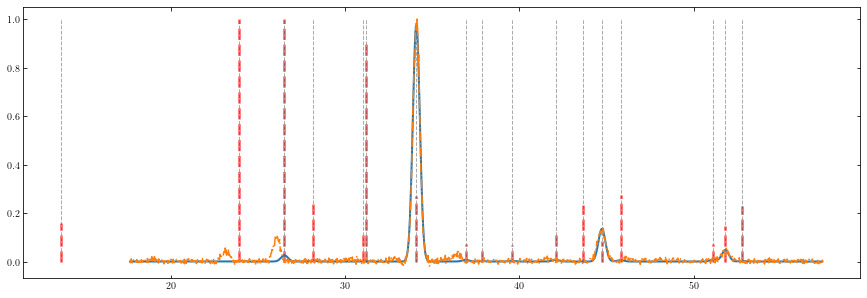

In [27]:
figure(figsize=(15,5))
g = profilo_gauss_newton[out.argmin()]
s =g.spectra

for _ in range(64):
    g.calibration_nobeta()
print(g.dz)
print(g.gamma)
    
vlines(g.mu,0,g.i,'r',alpha=0.5,ls='--',lw=3)
plot(g.theta,g.z,'-',lw=2)
plot(s.theta,s.intensity,'-.')
vlines(g.mu,0,1,'k',alpha=0.33,ls='--',lw=1)

vlines(g.mu[g.gamma<0],0,1,'c',alpha=1,ls='--',lw=3)

In [28]:
a = array([g.opt[0] for g in profilo_gauss_newton])
a = a.reshape(95,170)
a.max(),a.argmin()

(-1073.41193981386, 5598)

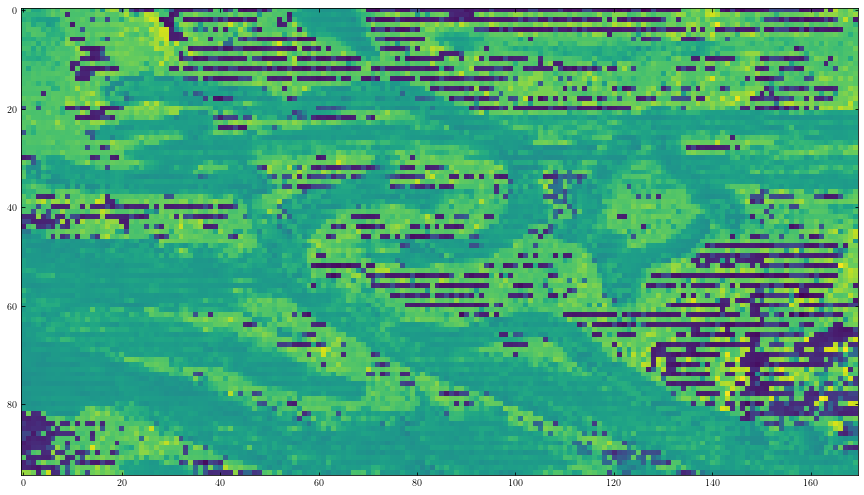

In [29]:
%matplotlib inline
figure(figsize=(15,15))
imshow(a[::-1])

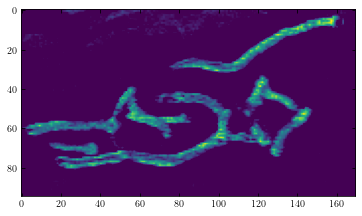

In [30]:
imshow(xrd_data.inverted[:,:,185],vmin=50)